In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

In [2]:
def is_hermitian(v):
    v2 = v[1:]
    res = v2 - v2[::-1].conj()
    return jnp.allclose(jnp.imag(res), 0, atol=1e-5) and jnp.allclose(jnp.real(res), 0, atol=1e-5)
def S(k, alpha=1e2, beta=1e5):
    return beta*jnp.exp(-(1/alpha) * k**2)
def sample(key, n, S=S):
    w_hat = jnp.zeros(n, dtype=jnp.complex64)
    keys = random.split(key, n)

    w_hat = w_hat.at[0].set(random.normal(keys[0])) # w^ <- N(0, 1)
    for k in range(1, n//2):
        real = random.normal(keys[2*k]) * S(k) * 0.5
        img = random.normal(keys[2*k+1]) * S(k) * 0.5
        w_hat = w_hat.at[k].set(real + 1j * img)
        w_hat = w_hat.at[n-k].set(real - 1j * img)
    if n % 2 == 0:
        #assert w_hat[n//2] == 0
        w_hat = w_hat.at[n//2].set(random.normal(keys[n-1]) * S(n//2))# Nyquist
    #assert is_hermitian(w_hat), "The generated vector is not hermitian"
    #assert jnp.allclose(jnp.imag(jnp.fft.ifft(w_hat)), 0, atol=1e-3)
    return jnp.fft.ifft(w_hat).astype(jnp.float32) / jnp.sqrt(n), w_hat


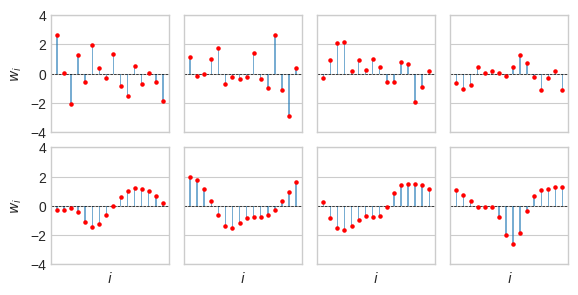

In [3]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(6, 3), sharey=True)
key = random.PRNGKey(2)
n = 16
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        if i == 0: # second row
            key, key_ = random.split(key)
            samples = random.normal(key_, (16,))
        if i == 1: # first row
            key, key_ = random.split(key)
            samples, w_hat = sample(key_, 16, S=lambda x: S(x, alpha=5, beta=70))
        ax.bar(range(len(samples)), samples, width=0.2, label='Bar', alpha=0.6)
        ax.scatter(range(len(samples)), samples, color='red', label='Scatter', zorder=5, s=5)
        ax.axhline(0, color='black', lw=0.5, linestyle='--')
        if i == 1:
            ax.set_xlabel("$i$")
        if j == 0:
            ax.set_ylabel("$w_i$")
        ax.set_xticks([])
        #ax.set_yticks([])
        ax.set_ylim(-4,4)
plt.tight_layout() 
    #plt.plot(range(len(samples)), samples, alpha=0.5)

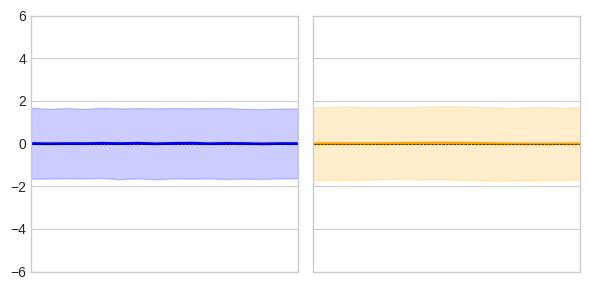

In [136]:
total_samples = 10000
n_per_sample = 16
samples_from_gaussian = random.normal(key, (total_samples, n_per_sample))
samples_from_spectral = jax.vmap(lambda key: sample(key, n_per_sample, S=lambda x: S(x, alpha=5, beta=70))[0], in_axes=(0))(random.split(key, total_samples))
samples_from_gaussian.shape, samples_from_spectral.shape
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(6, 3), sharey=True)
for i, ax in enumerate(axs):
    if i == 0: # second row
        samples = samples_from_gaussian
    if i == 1: # first row
        samples = samples_from_spectral
    mean = jnp.mean(samples, axis=0)
    percentiles = jnp.percentile(samples, jnp.array([5, 95]), axis=0)
    ax.plot(range(len(mean)), mean, color='blue' if i == 0 else 'orange', lw=2, label='Mean')
    ax.fill_between(range(len(mean)), percentiles[0], percentiles[1], alpha=0.2, color='blue' if i == 0 else 'orange', label='5-95%')
    ax.axhline(0, color='black', lw=0.5, linestyle='--')
    ax.set_xticks([])
    #ax.set_yticks([])
    ax.set_ylim(-6, 6)
    ax.set_xlim(0, n_per_sample - 1)
plt.tight_layout()

In [5]:
def S(k, alpha=1e2, beta=1e5):
    return beta*jnp.exp(-(1/alpha) * k**2)
def sample(key, n, kernel=S):
    w_hat = jnp.zeros(n, dtype=jnp.complex64)
    keys = random.split(key, n)
    w_hat = w_hat.at[0].set(random.normal(keys[0])) # w^ <- N(0, 1)
    for k in range(1, n//2):
        real = random.normal(keys[2*k]) * kernel(k) * 0.5
        img = random.normal(keys[2*k+1]) * kernel(k) * 0.5
        w_hat = w_hat.at[k].set(real + 1j * img)
        w_hat = w_hat.at[n-k].set(real - 1j * img)
    if n % 2 == 0:
        assert w_hat[n//2] == 0
        w_hat = w_hat.at[n//2].set(random.normal(keys[n-1]) * kernel(k))# Nyquist
    assert jnp.allclose(jnp.imag(jnp.fft.ifft(w_hat)), 0, atol=1e-3)
    return jnp.fft.ifft(w_hat).astype(jnp.float32) / jnp.sqrt(n), w_hat

In [6]:
jnp.exp(-0.01*3**2)

Array(0.9139312, dtype=float32, weak_type=True)

In [7]:
from itertools import combinations_with_replacement
def S(k1, k2, alpha=1e1, beta=1e2):
    return beta*jnp.exp(-(1/alpha) * (k1**2 + k2**2))
def sample(key, n, kernel=S):
    w_hat = jnp.zeros((n, n), dtype=jnp.complex64)
    keys = random.split(key, (n, n))

    w_hat = w_hat.at[0].set(random.normal(keys[0, 0])) # w^ <- N(0, 1)
    for k1, k2 in combinations_with_replacement(range(1, n//2), 2):
        real = random.normal(keys[2*k1, 2*k2]) * kernel(k1, k2) * 0.5
        img = random.normal(keys[2*k1+1, 2*k2 + 1]) * kernel(k1, k2) * 0.5
        w_hat = w_hat.at[k1, k2].set(real + 1j * img)
        w_hat = w_hat.at[n-k1, n-k2].set(real - 1j * img)
    if n % 2 == 0:
        assert w_hat[n//2, n//2] == 0
        w_hat = w_hat.at[n//2].set(random.normal(keys[n-1, n-1])) * kernel(k1, k2)# Nyquist
    assert jnp.allclose(jnp.imag(jnp.fft.ifft2(w_hat)), 0, atol=1e-5)
    return jnp.fft.ifft2(w_hat).astype(jnp.float32) / jnp.sqrt(n)

3.5517862


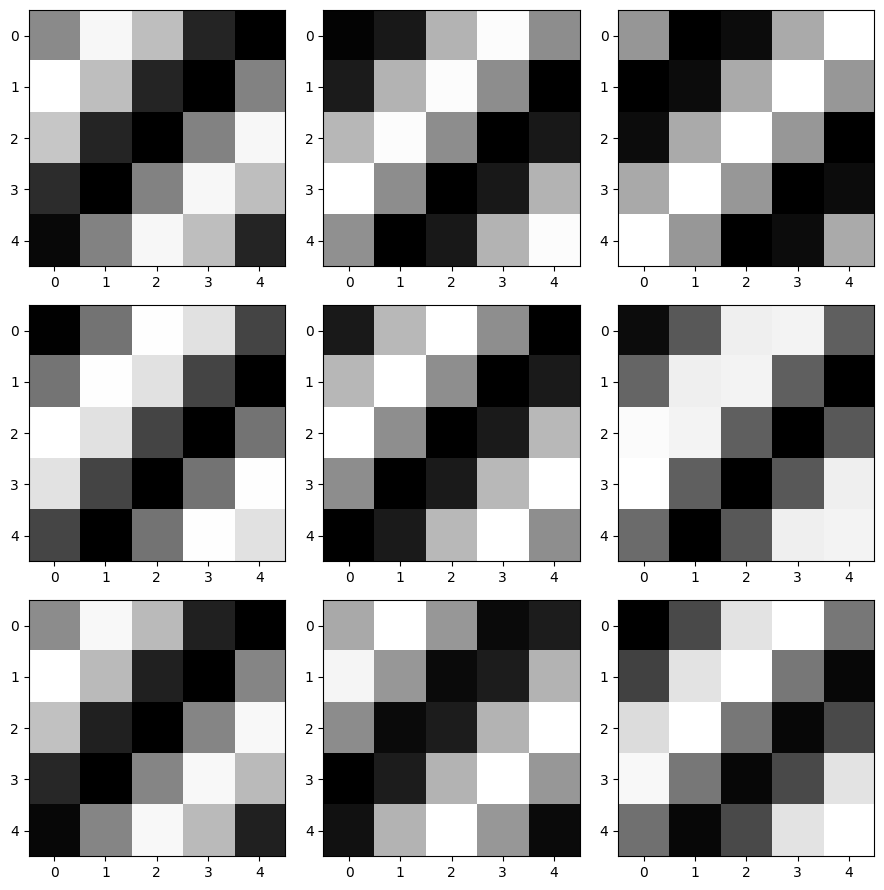

In [8]:
key, key_ = random.split(key)
print(sample(key_, 5).max())
fig, axs = plt.subplots(3, 3, figsize=(9,9))
axs = axs.ravel()
for i in range(9):
    key, key_ = random.split(key)
    axs[i].imshow(sample(key_, 5), cmap='gray')
fig.tight_layout()

In [9]:
range(1,5//2)

range(1, 2)

/home/rasmuslovstad/Programs/assignments/thesis/.venv/lib64/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/rasmuslovstad/Programs/assignments/thesis/.venv/lib64/python3.12/site-packages/numpy/lib/_histograms_impl.py:857: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/rasmuslovstad/Programs/assignments/thesis/.venv/lib64/python3.12/site-packages/matplotlib/axes/_axes.py:7096: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


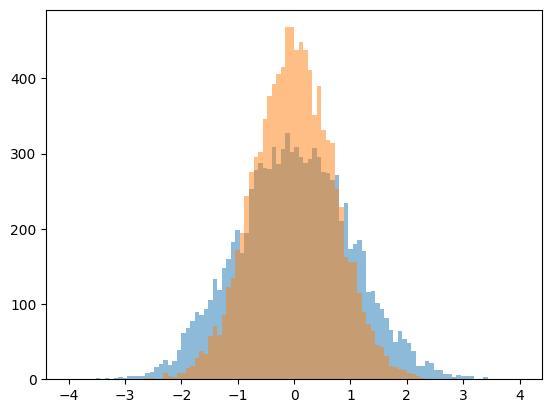

In [10]:
N = 10_000
rvs = jax.random.normal(key, (N//2,2))
comp_gauss = jnp.zeros(N, dtype=jnp.complex64)
comp_gauss = comp_gauss.at[0].set(rvs[0,0])
comp_gauss = comp_gauss.at[1:N//2].set(rvs[1:N//2,0]*0.5 + 1j*rvs[1:N//2,1] * 0.5)
comp_gauss = comp_gauss.at[N//2].set(rvs[N//2,0])
comp_gauss = comp_gauss.at[N//2+1:N].set(rvs[N//2:0:-1,0]*0.5 - 1j*rvs[N//2:0:-1,1] * 0.5)

assert jnp.allclose(jnp.imag(jnp.fft.ifft(comp_gauss)), 0), "Not Hermitian"

plt.hist(rvs.flatten(), bins=100, range=(-4,4), alpha=0.5)
plt.hist(jnp.fft.ifft(comp_gauss) * jnp.sqrt(N), bins=100, range=(-4,4), alpha=0.5)
plt.show()

In [11]:
# Does the Nyquist part always result in real?
example_nyquist = 42.0 + 0.0j
n = 1
example_nyquist * jnp.exp(1j * 2*jnp.pi*2*n)

Array(42.+1.4687026e-05j, dtype=complex64, weak_type=True)

In [92]:
# Does the imaginary part in a Hermitean vector always cancel out?
n = 1
herm_v = lambda img: jnp.array([1.0 + 0.0j, 3.2 + img, 3.2 - img])
jnp.allclose(jnp.fft.ifft(herm_v(100.0j)), jnp.fft.ifft(herm_v(100.0j)))

Array(True, dtype=bool)

In [105]:
def man_ifft(w_hat):
    N = len(w_hat)
    return jnp.array([jnp.sum(w_hat * jnp.exp(1j * 2*jnp.pi*k/N*jnp.arange(N))) for k in range(N)]) / N
herm_v(10.0j) * jnp.exp(1j * 2*jnp.pi*1/3*jnp.arange(3))

Array([  1.      +0.j       , -10.260254-2.2287192j,
       -10.260254+2.2287176j], dtype=complex64)

In [117]:
n = 1
[2*3.2*jnp.cos(2*jnp.pi*n*k/3) - 2*10.0*jnp.sin(2*jnp.pi*n*k/3) for k in jnp.arange(3)]

[Array(6.4, dtype=float32, weak_type=True),
 Array(-20.520508, dtype=float32, weak_type=True),
 Array(14.120509, dtype=float32, weak_type=True)]

In [71]:
w = 3.2 + 10j
w * jnp.exp(1j * 2*jnp.pi*1/3)

Array(-10.260254-2.2287192j, dtype=complex64, weak_type=True)

In [58]:
#w * jnp.cos(2*jnp.pi*1/3) + w * 1j * jnp.sin(2*jnp.pi*1/3)
w * 1j * jnp.sin(2*jnp.pi*1/3)

Array(-8.660254+2.7712812j, dtype=complex64, weak_type=True)

In [91]:
jnp.exp(1j*2*jnp.pi*95/100)

Array(0.95105654-0.30901694j, dtype=complex64, weak_type=True)

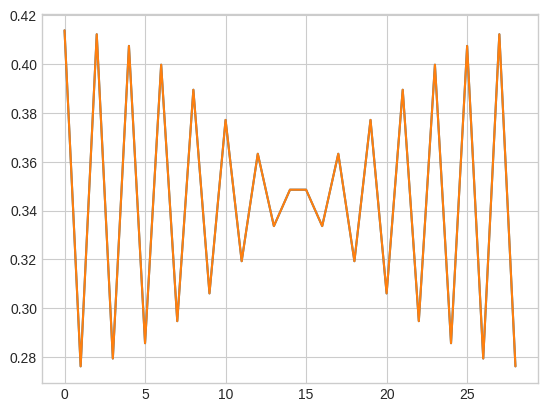

In [ ]:
n = 29
x = jnp.zeros(n)
x = x.at[0].set(10.0)
x = x.at[15].set(1.0 - 10.0j)
x = x.at[-15].set(1.0 + 10.0j)
x_f = jnp.fft.ifft(x)
plt.plot(x_f.real)

x = jnp.zeros(n)
x = x.at[0].set(10.0)
x = x.at[15].set(1.0 + 100.0j)
x = x.at[-15].set(1.0 - 100.0j)
x_f = jnp.fft.ifft(x)
plt.plot(x_f.real)

In [115]:
c = 4j
x = jnp.fft.ifft(jnp.array([1,2 + c,3 + c,4, 3 - c, 2 - c]))
x.real

Array([ 2.5       , -2.976068  ,  0.        , -0.16666667,  0.        ,
        1.6427344 ], dtype=float32)

In [28]:
@jax.jit
def inner_sample_w_hat(normals, S_k):
    n = normals.shape[-1]
    k = jnp.arange(n)

    real = normals[2 * k] * S_k * 0.5
    img = normals[2 * k + 1] * S_k * 0.5

    w_hat_real = jnp.where((k > 0) & (k < n // 2), real, 0.0)
    w_hat_img = jnp.where((k > 0) & (k < n // 2), img, 0.0)

    w_hat = w_hat_real + 1j * w_hat_img
    w_hat = w_hat.at[0].set(normals[0] * S_k[0])
    w_hat = w_hat.at[n // 2].set(jnp.where(n % 2 == 0, normals[n - 1] * S_k[n // 2], 0.0))
    w_hat = w_hat.at[n - k].set(jnp.where((k > 0) & (k < n // 2), w_hat_real - 1j * w_hat_img, w_hat[n - k]))

    return w_hat

n = 6
normals = jax.random.normal(random.PRNGKey(123), (n,))
S_k = S(jnp.arange(n), alpha=5, beta=70)
w_hat = inner_sample_w_hat(normals, S_k)
w_hat

Array([114.51628    +0.j      ,   0.63397396-15.166734j,
       -10.798531  -17.108517j, -12.587743   +0.j      ,
       -10.798531  +17.108517j,   0.63397396+15.166734j], dtype=complex64)

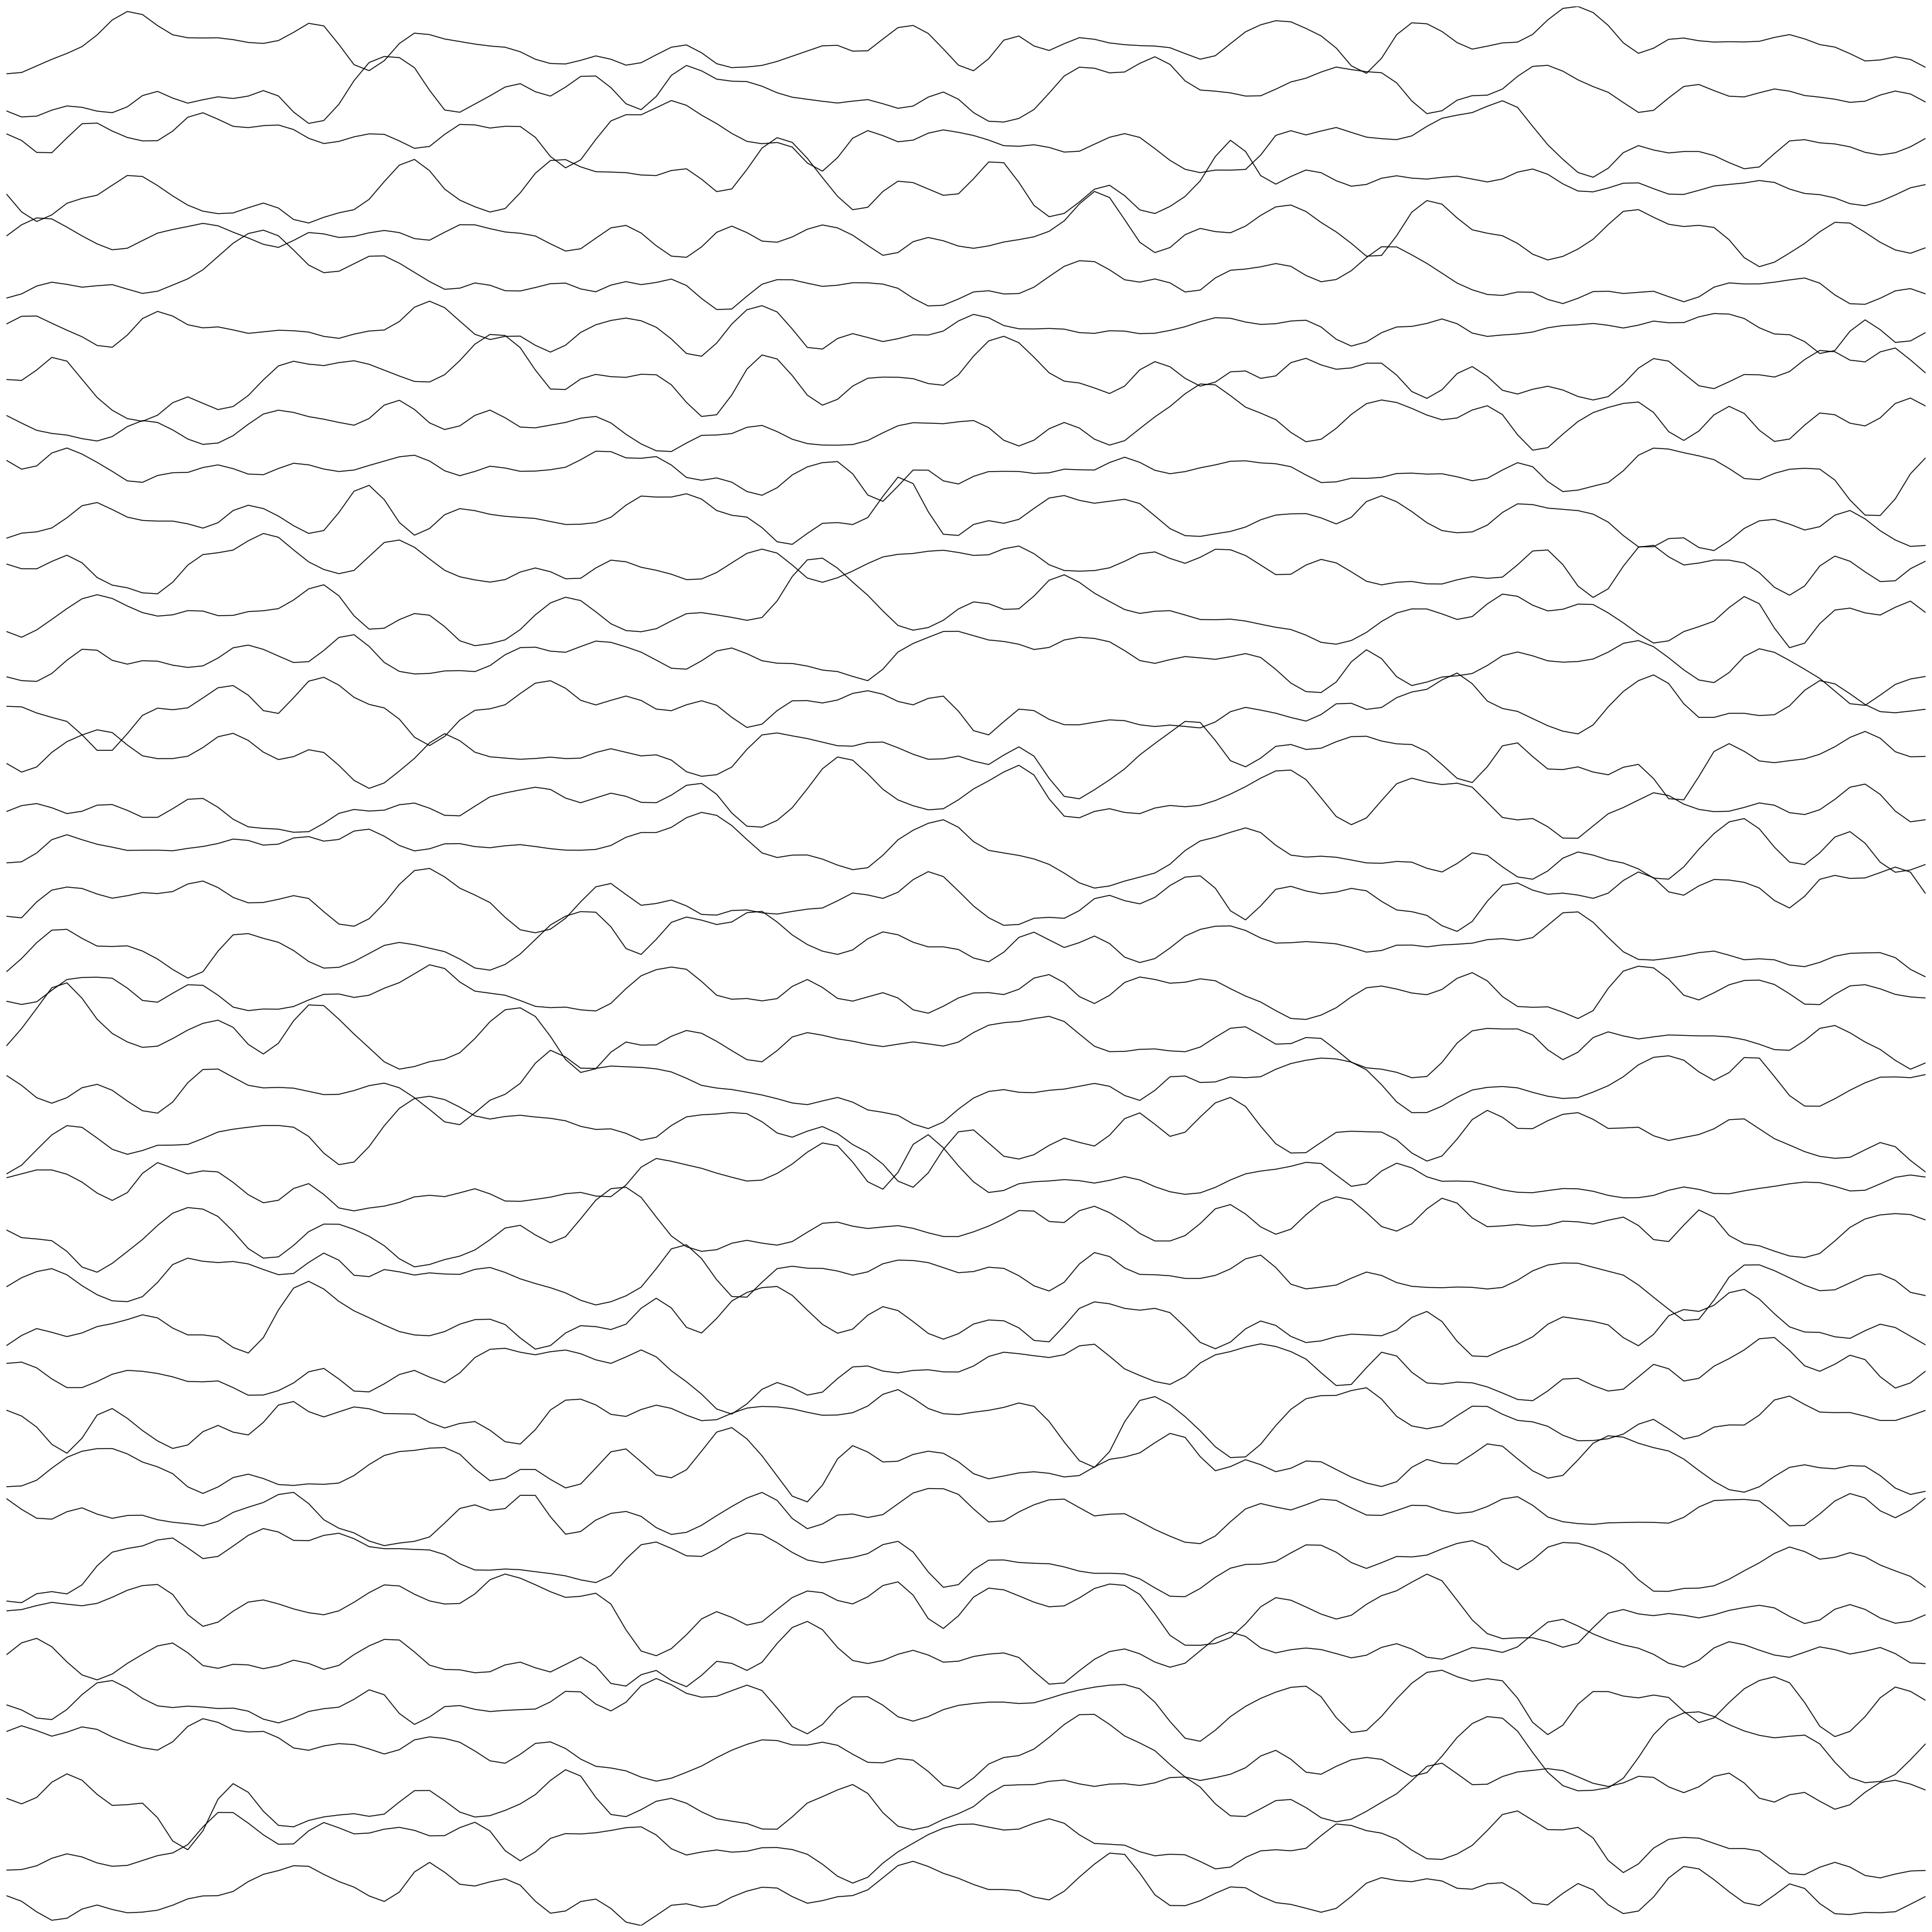

In [15]:
num_lines = 40
n = 128
key_seq = random.split(key, num_lines)
lines = []
for k in key_seq:
    line, _ = sample(k, n, S=lambda x: S(x, alpha=500, beta=500))
    lines.append(line)

plt.figure(figsize=(30, 30))
offset = 4
for i, line in enumerate(lines):
    plt.plot(jnp.arange(n), line + i * offset, color='black', alpha=1, lw=1)
plt.axis('off')
plt.margins(0)
plt.tight_layout()
plt.show()